<h1><center>RSNA Screening Mammography Breast Cancer Detection. Part 2 - Modeling </center></h1>

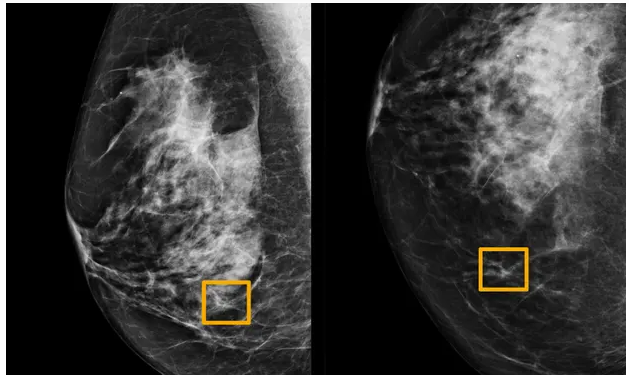

# Table of contents

* [Installing and importing necessary dependancies](#dependancies)
* [Competition conditions and constraints](#Competition_conditions)
    * [The competition metric](#metric)
    * [Code Competition](#Code_Competition)
* [Initialization](#Initialization)
* [Stratified splits for training](#Stratified_splits)
* [Useful functions](#functions)
* [Creating the learner and training](#learner_training)
* [Plot classes with least precision](#least_precision)
* [Confusion Matrix](#Confusion_Matrix)
* [Predicting on test](#test_prediction)
* [Submission](#Submission)

## Installing and importing necessary dependancies

In [1]:
!unzip -q ../input/timm-with-dependencies/timm_all -d timm-with-dependencies
!pip install --no-index --find-links timm-with-dependencies timm
!pip install /kaggle/input/dicomsdl-offline-installer/dicomsdl-0.109.1-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl

import os
import multiprocessing as mp
from pathlib import Path

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import glob
import cv2

from fastai.vision.learner import *
from fastai.data.all import *
from fastai.vision.all import *
from fastai.metrics import ActivationType, error_rate, accuracy

from sklearn.model_selection import StratifiedKFold
from collections import defaultdict
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut


from timm.models.layers.adaptive_avgmax_pool import SelectAdaptivePool2d
from torch.nn import Flatten

## Competition conditions and constraints

### The competition metric

It is always a good idea to understand exactly the type of predictions our model will be required to deliver.

The metric that the organizers opted for here is the probabilistic F1 score:

$pF_1 = 2\frac{pPrecision \cdot pRecall}{pPrecision+pRecall}$

with:

$pPrecision = \frac{pTP}{pTP+pFP}$

$pRecall = \frac{pTP}{pTP+pFN}$

You can find a Python implementation of the metric [here](https://www.kaggle.com/code/sohier/probabilistic-f-score)

Our model should output the likelihood of cancer in the corresponding image.

So what are the labels we will train on?

This is implements the probablistic F score described [here](https://aclanthology.org/2020.eval4nlp-1.9.pdf)

### Code Competition

Submissions to this competition must be made through Notebooks. In order for the "Submit" button to be active after a commit, the following conditions must be met:

- CPU Notebook <= 9 hours run-time
- GPU Notebook <= 9 hours run-time
- Internet access disabled
- Freely & publicly available external data is allowed, including pre-trained models
- Submission file must be named "submission.csv"

## Initialization

In [2]:
# Number of splits. 
num_splits = 4

resize_to = (512, 512)

data_path = '/kaggle/input/rsna-breast-cancer-detection'
train_image_dir = \
    '/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_cv2_512'
test_dicom_dir = \
    '/kaggle/input/rsna-breast-cancer-detection/test_images'
model_path = \
    '/kaggle/input/rsna-trained-model-weights/tf_effv2_s_208_402/tf_effv2_s_208_402'

# model_path = \
#     '/kaggle/input/rsna-trained-model-weights/res18_119_80/res18_119_80'

# Data types

label_smoothing_weights = torch.tensor([1, 10]).float()
if torch.cuda.is_available():
    label_smoothing_weights = label_smoothing_weights.cuda()

## Stratified splits for training

In [3]:
# Read train.csv file
train_csv = pd.read_csv(f'{data_path}/train.csv')
# group by "patient_id"
patient_id_any_cancer = train_csv.groupby('patient_id'
        ).cancer.max().reset_index()
# StratifiedKFold because of imbalanced data
skf = StratifiedKFold(num_splits, shuffle=True, random_state=42)
splits = list(skf.split(patient_id_any_cancer.patient_id,
              patient_id_any_cancer.cancer))

In [4]:
train_csv.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True


In [5]:
patient_id_any_cancer.head()

,patient_id,cancer
0,5,0
1,25,0
2,28,0
3,30,0
4,33,0


In [6]:
splits

[(array([    2,     3,     5, ..., 11909, 11910, 11912]),
  array([    0,     1,     4, ..., 11898, 11904, 11911])),
 (array([    0,     1,     2, ..., 11908, 11911, 11912]),
  array([    3,     9,    10, ..., 11903, 11909, 11910])),
 (array([    0,     1,     2, ..., 11909, 11910, 11911]),
  array([    5,    16,    20, ..., 11906, 11907, 11912])),
 (array([    0,     1,     3, ..., 11910, 11911, 11912]),
  array([    2,     6,     7, ..., 11901, 11905, 11908]))]

## Useful functions

In [8]:
#https://www.kaggle.com/competitions/rsna-breast-cancer-detection/discussion/369267  
def pfbeta_torch(preds, labels, beta=1):
    """calculation of fbeta.

    Args:
        preds: prediction.
        labels
        beta=1
        
    """
    if preds.dim() != 2 or preds.dim() == 2 and preds.shape[1] != 2:
        raise ValueError('Houston, we got a problem')
    preds = preds[:, 1]
    preds = preds.clip(0, 1)
    y_true_count = labels.sum()
    ctp = preds[labels == 1].sum()
    cfp = preds[labels == 0].sum()
    beta_squared = beta * beta
    c_precision = ctp / (ctp + cfp)
    c_recall = ctp / y_true_count
    if c_precision > 0 and c_recall > 0:
        result = (1 + beta_squared) * (c_precision * c_recall) \
            / (beta_squared * c_precision + c_recall)
        return result
    else:
        return 0.0

# https://www.kaggle.com/competitions/rsna-breast-cancer-detection/discussion/369886    
def pfbeta_torch_thresh(preds, labels):
    """calculation of fbeta with threshold.

    Args:
        preds: prediction.
        labels
        
    """
    optimized_preds = optimize_preds(preds, labels)
    return pfbeta_torch(optimized_preds, labels)

def optimize_preds(
    preds,
    labels=None,
    thresh=None,
    return_thresh=False,
    print_results=False,
    ):
    """optimize predictions.

    Args:
        preds: prediction.
        labels
        thresh: threshold
        
    """
    preds = preds.clone()
    if labels is not None:
        without_thresh = pfbeta_torch(preds, labels)

    if not thresh and labels is not None:
        threshs = np.linspace(0, 1, 101)
        f1s = [pfbeta_torch((preds > thr).float(), labels) for thr in
               threshs]
        idx = np.argmax(f1s)
        (thresh, best_pfbeta) = (threshs[idx], f1s[idx])

    preds = (preds > thresh).float()

    if print_results:

        print(f'without optimization: {without_thresh}')
        pfbeta = pfbeta_torch(preds, labels)
        print(f'with optimization: {pfbeta}')
        print(f'best_thresh = {thresh}')

    if return_thresh:
        return thresh
    return preds

fn2label = {fn: cancer_or_not for fn, cancer_or_not in zip(train_csv['image_id'].astype('str'), train_csv['cancer'])}

def splitting_func(paths):
    """splitting function.

    Args:
        paths: path.
        
    """
    train = []
    valid = []
    for (idx, path) in enumerate(paths):
        if int(path.parent.name) \
            in patient_id_any_cancer.iloc[splits[SPLIT][0]].patient_id.values:
            train.append(idx)
        else:
            valid.append(idx)
    return (train, valid)

def label_func(path):
    """label function.

    Args:
        paths: path.
        
    """
    return fn2label[path.stem]

def get_items(image_dir_path):
    """get items.

    Args:
        paths: image directory path.
        
    """
    items = []
    for p in get_image_files(image_dir_path):
        items.append(p)
        if p.stem in fn2label and int(p.parent.name) \
            in patient_id_any_cancer.iloc[splits[SPLIT][0]].patient_id.values:
            if label_func(p) == 1:
                for _ in range(5):
                    items.append(p)
    return items

In [9]:
def get_dataloaders():
    """get data loaders.
        
    """
    train_image_path = train_image_dir

    dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                       get_items=get_items, get_y=label_func,
                       splitter=splitting_func, batch_tfms=[Flip()])
    dsets = dblock.datasets(train_image_path)
    return dblock.dataloaders(train_image_path, batch_size=32)

def get_learner(arch=resnet18):
    """get learner.

    Args:
        arch: model.
        
    """
    learner = vision_learner(
        get_dataloaders(),
        arch,
        custom_head=nn.Sequential(SelectAdaptivePool2d(pool_type='avg',
                                  flatten=Flatten()), nn.Linear(1280,
                                  2)),
        metrics=[error_rate, AccumMetric(pfbeta_torch,
                 activation=ActivationType.Softmax, flatten=False),
                 AccumMetric(pfbeta_torch_thresh,
                 activation=ActivationType.Softmax, flatten=False)],
        loss_func=CrossEntropyLossFlat(weight=torch.tensor([1,
                50]).float()),
        pretrained=True,
        normalize=False,
        ).to_fp16()
    return learner

In [10]:
#create a dls for a gven SPLIT.
SPLIT = 0 # as example.
dls = get_dataloaders()

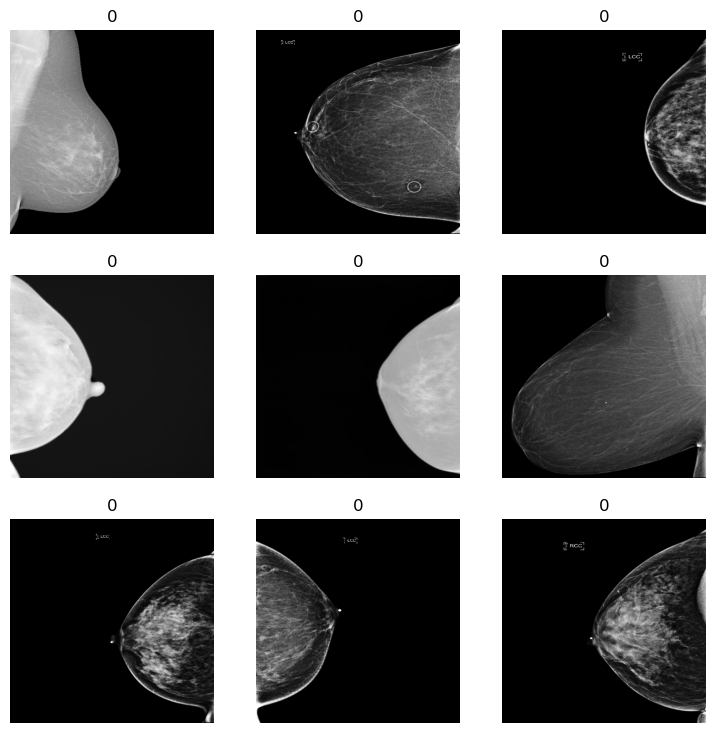

In [11]:
dls.show_batch()

## Creating the learner and training

In [12]:
# This is a dependency that is needed for reading DICOM images

try:
    import pylibjpeg
except:
    !rm -rf /root/.cache/torch/hub/checkpoints/
    !mkdir -p /root/.cache/torch/hub/checkpoints/
    !pip install /kaggle/input/rsna-2022-whl/{pydicom-2.3.0-py3-none-any.whl,pylibjpeg-1.4.0-py3-none-any.whl,python_gdcm-3.0.15-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl}
    !pip install /kaggle/input/rsna-2022-whl/{torch-1.12.1-cp37-cp37m-manylinux1_x86_64.whl,torchvision-0.13.1-cp37-cp37m-manylinux1_x86_64.whl}

# copying the pretrained weights

if not os.path.exists('/root/.cache/torch/hub/checkpoints/'):
        os.makedirs('/root/.cache/torch/hub/checkpoints/')
!cp '/kaggle/input/pretrained-model-weights-for-fastai/resnet18-f37072fd.pth' '/root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth'
!cp '/kaggle/input/pretrained-model-weights-for-fastai/tf_efficientnetv2_s-eb54923e.pth' '/root/.cache/torch/hub/checkpoints/tf_efficientnetv2_s-eb54923e.pth'

In [13]:
%%time

preds, labels = [], []

SPLIT = 0 # our learner needs this to construct its dataloaders...
learn = get_learner('tf_efficientnetv2_s')
#learn = get_learner('resnet18')

CPU times: user 1min 58s, sys: 1.5 s, total: 1min 59s
Wall time: 2min 16s


In [14]:
learn.summary()

Sequential (Input shape: 32 x 3 x 512 x 512)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 24 x 256 x 256 
Conv2dSame                                648        False     
Identity                                                       
SiLU                                                           
Conv2d                                    5184       False     
Identity                                                       
SiLU                                                           
Identity                                                       
Conv2d                                    5184       False     
Identity                                                       
SiLU                                                           
Identity                                                       
____________________________________________________________________________
                     32 x 96 x 128 x 128 
Conv2dSame                

In [15]:
# Build a Classification Interpretation object from our learn model
# it can show us where the model made the worse predictions:
interp = ClassificationInterpretation.from_learner(learn)

/opt/conda/lib/python3.7/site-packages/fastai/metrics.py:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = F.softmax(pred, dim=self.dim_argmax)


## Plot classes with least precision 

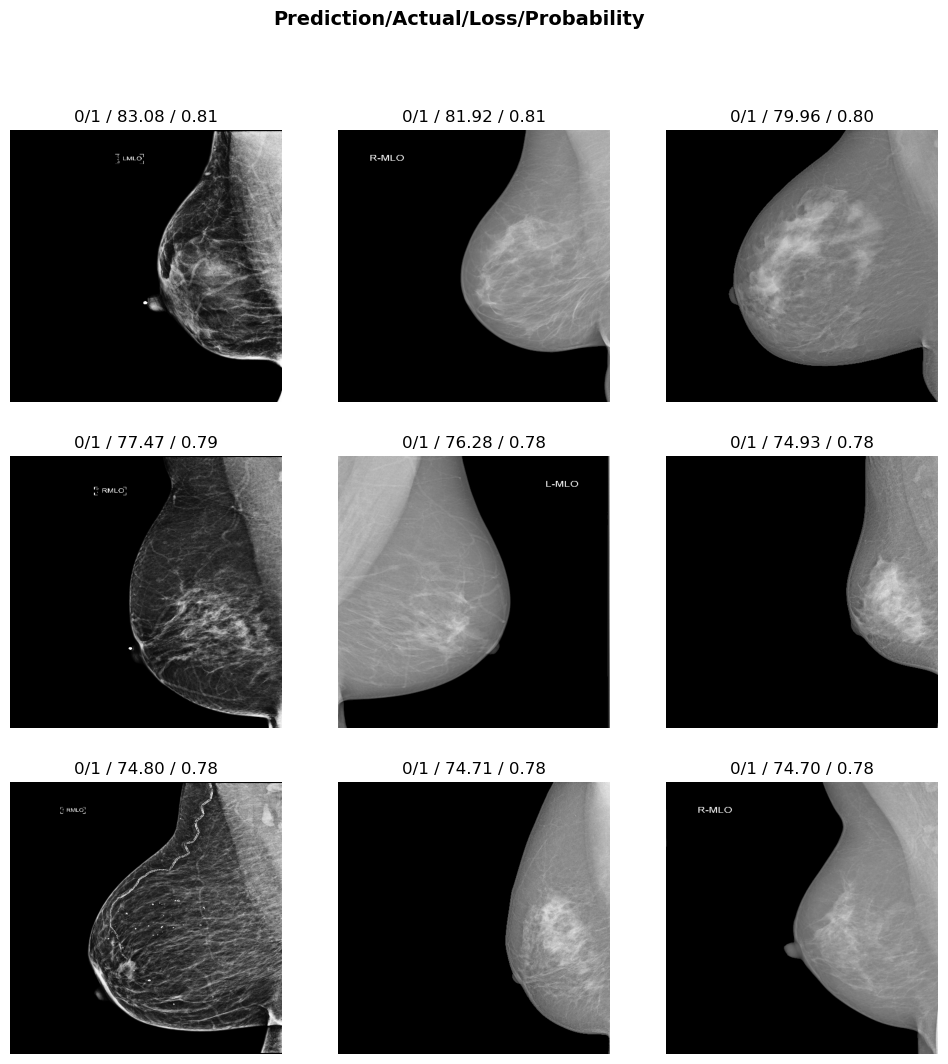

In [16]:
# Plot the top ‘n’ classes where the classifier has least precision.
interp.plot_top_losses(9, figsize=(12,12))

## Confusion Matrix

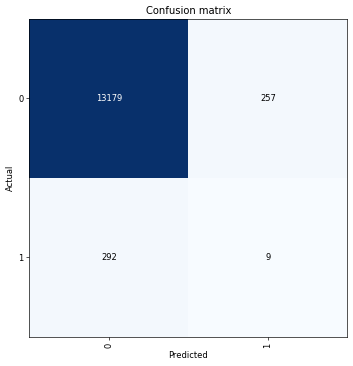

In [17]:
interp.plot_confusion_matrix(figsize=(6,6), dpi=60)

We see that 13179 non-cancers were predicted correctly against only 257. On the other hand, 292 cancers were predicted as non-cancer for only 9 cancers were predicted correctly.

# Predicting on test<a id="section-two">

In [19]:
!rm -rf test_resized_{resize_to[0]}

def dicom_file_to_ary(path):
    dcm_file = dicomsdl.open(str(path))
    data = dcm_file.pixelData()

    data = (data - data.min()) / (data.max() - data.min())

    if dcm_file.getPixelDataInfo()['PhotometricInterpretation'] \
        == 'MONOCHROME1':
        data = 1 - data

    data = cv2.resize(data, resize_to)
    data = (data * 255).astype(np.uint8)
    return data

directories = list(Path(test_dicom_dir).iterdir())

def process_directory(directory_path):
    parent_directory = str(directory_path).split('/')[-1]
    !mkdir -p test_resized_{resize_to[0]}/{parent_directory}
    for image_path in directory_path.iterdir():
        processed_ary = dicom_file_to_ary(image_path)
        cv2.imwrite(
            f'test_resized_{resize_to[0]}/{parent_directory}/{image_path.stem}.png',
            processed_ary
        )

with mp.Pool(mp.cpu_count()) as p:
    p.map(process_directory, directories)

In [20]:
%%time

preds_all = []

test_dl = learn.dls.test_dl(get_image_files(f'test_resized_{resize_to[0]}'))

for SPLIT in range(num_splits):
    print(SPLIT,(f'{model_path}/{SPLIT}'))
    learn.load(f'{model_path}/{SPLIT}')
    (preds, _) = learn.get_preds(dl=test_dl)
    preds_all.append(preds)

0 /kaggle/input/rsna-trained-model-weights/tf_effv2_s_208_402/tf_effv2_s_208_402/0


1 /kaggle/input/rsna-trained-model-weights/tf_effv2_s_208_402/tf_effv2_s_208_402/1


2 /kaggle/input/rsna-trained-model-weights/tf_effv2_s_208_402/tf_effv2_s_208_402/2


3 /kaggle/input/rsna-trained-model-weights/tf_effv2_s_208_402/tf_effv2_s_208_402/3


CPU times: user 3.53 s, sys: 1.3 s, total: 4.83 s
Wall time: 18.9 s


In [21]:
threshold = 0.4
preds = torch.zeros_like(preds_all[0])
for pred in preds_all:
    preds += pred

preds /= num_splits

preds = optimize_preds(preds, thresh=threshold)
image_ids = [path.stem for path in test_dl.items]

image_id2pred = defaultdict(lambda: 0)
for image_id, pred in zip(image_ids, preds[:, 1]):
    image_id2pred[int(image_id)] = pred.item()

<a id="section-three"></a>
# Submission

In [22]:
test_csv = \
    pd.read_csv('/kaggle/input/rsna-breast-cancer-detection/test.csv')

prediction_ids = []
preds = []

for (_, row) in test_csv.iterrows():
    prediction_ids.append(row.prediction_id)
    preds.append(image_id2pred[row.image_id])

submission = pd.DataFrame(data={'prediction_id': prediction_ids,
                          'cancer': preds}).groupby('prediction_id'
        ).max().reset_index()
submission.head()

,prediction_id,cancer
0,10008_L,0.0
1,10008_R,0.0


In [23]:
submission.to_csv('submission.csv', index=False)